# Membership inference attack

This code trains a binary classification model and then performs a membership inference attack (MIA) to determine whether a given sample was part of the training data based on confidence scores.

We import our required libraries, iris dataset and prepare for training.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Load dataset
iris = load_iris()
X, y = iris.data, iris.target

# Convert to binary classification for simplicity (Setosa vs Non-Setosa)
y = (y == 0).astype(int)

# Split into training and holdout sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
X_train_target, X_attack, y_train_target, y_attack = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

We define a simple feedforward neural network with 16 neurons in the first layer (with ReLU activation), 8 neurons in the second layer (also with ReLU activation), 1 neuron with Sigmoid activation (for binary classification).
Uses Binary Crossentropy Loss because it's a binary classification task.

In [2]:
# Train the Target Model
target_model = Sequential([
    Dense(16, activation='relu', input_shape=(X.shape[1],)),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification output
])

target_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
target_model.fit(X_train_target, y_train_target, epochs=20, batch_size=8, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


We predict labels for the clean test dataset and compute accuracy to ensure the target model performs well before attempting an attack

In [3]:
# Evaluate on clean test set
y_pred_test = (target_model.predict(X_test) > 0.5).astype(int)
print(f"✅ Target Model Test Accuracy: {accuracy_score(y_test, y_pred_test):.2f}")

# Step 2: Collect Confidence Scores for Attack Dataset
def get_confidence_scores(model, X):
    return model.predict(X).flatten()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
✅ Target Model Test Accuracy: 0.61


 We extract confidence scores (probabilities) for samples in both the training set and the test set. These confidence scores become the features for the attack model, as they often reveal whether a sample was in the training set.

In [4]:
# Get confidence scores from the target model
train_confidences = get_confidence_scores(target_model, X_train_target)
test_confidences = get_confidence_scores(target_model, X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


We create an attack dataset with:
Feature: The confidence score output by the target model.
Label:
1 → Sample was in the training set.
0 → Sample was not in the training set.
This allows the attack model to learn patterns in confidence scores that differentiate training data from unseen data.

In [5]:
# Create attack dataset: (confidence scores, was_in_training_set)
X_attack_data = np.concatenate([train_confidences, test_confidences]).reshape(-1, 1)
y_attack_labels = np.concatenate([np.ones(len(train_confidences)), np.zeros(len(test_confidences))])  # 1 = in training, 0 = not

# Step 3: Train the Attack Model
attack_model = Sequential([
    Dense(8, activation='relu', input_shape=(1,)),
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification output
])

attack_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
attack_model.fit(X_attack_data, y_attack_labels, epochs=20, batch_size=8, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


We then predict whether each confidence score corresponds to a training sample or not. If it's high, the attack is successful, meaning the model leaks information about its training data.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Membership Inference Attack Accuracy: 0.67


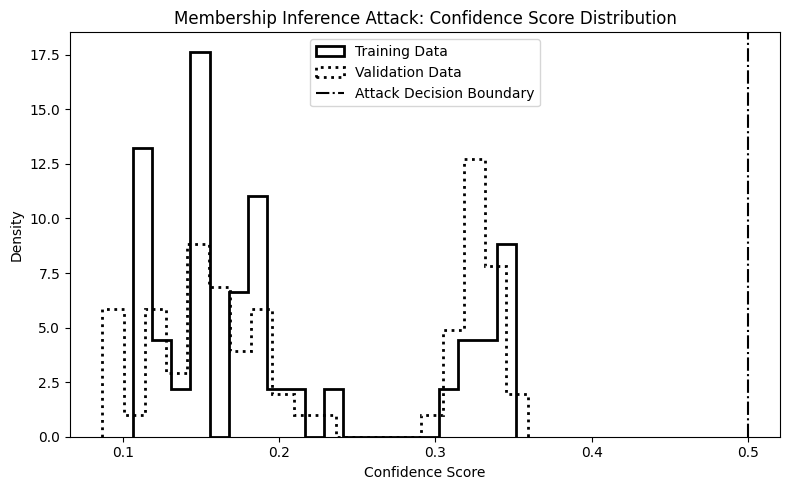

In [10]:
# Evaluate the attack model
y_pred_attack = (attack_model.predict(X_attack_data) > 0.5).astype(int)
attack_accuracy = accuracy_score(y_attack_labels, y_pred_attack)

print(f"Membership Inference Attack Accuracy: {attack_accuracy:.2f}")

# Step 4: Visualizing the Attack Model's Success (Greyscale-compatible with line styles)
plt.figure(figsize=(8, 5))

# Use density=True for probability density function (smooths visual comparison)
plt.hist(train_confidences, bins=20, density=True, histtype='step',
         linestyle='solid', linewidth=2, label="Training Data", color='black')
plt.hist(test_confidences, bins=20, density=True, histtype='step',
         linestyle='dotted', linewidth=2, label="Validation Data", color='black')

# Decision boundary
plt.axvline(0.5, color='black', linestyle='dashdot', linewidth=1.5, label="Attack Decision Boundary")

plt.xlabel("Confidence Score")
plt.ylabel("Density")
plt.legend()
plt.title("Membership Inference Attack: Confidence Score Distribution")
plt.tight_layout()
plt.show()
